This notebook contains a toy example to illustrate the difference between common approaches to uncertainty estimation and evidential deep learning. We do this for both classification and regression using the Iris dataset for classification and a synthetic dataset for regression.

## Classification Example

In [229]:
from sklearn import datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import lgamma
import torch.special as special
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from tqdm import tqdm
import math
from math import gamma
from operator import mul
import os
from typing import Optional, Dict
import scipy

IMG_PATH = "./img/"

if not os.path.exists(IMG_PATH):
    os.makedirs(IMG_PATH)

In [230]:
# Load dataset
iris_dataset = datasets.load_iris()

# Only retain the first two features per point - sepal length and sepal width
X_iris = iris_dataset.data[:, :2] 
y_iris = iris_dataset.target

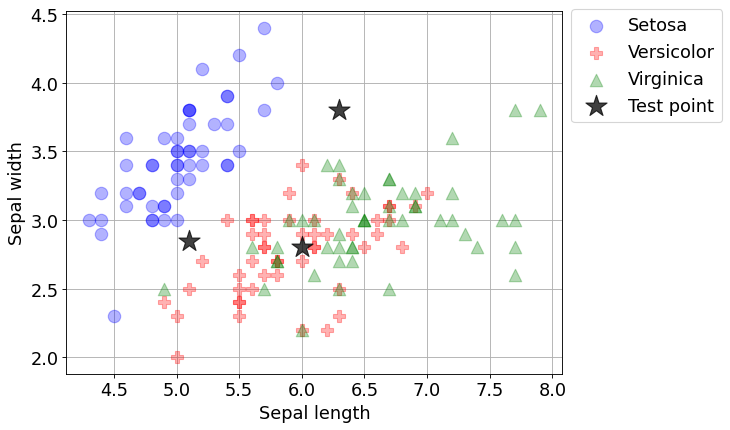

In [231]:
# Plot the dataset!
plt.figure(figsize=(8, 6), dpi=80)
plt.grid(visible=True)
ax = plt.gca()

for label, (marker, color, name) in enumerate(
        zip(["o", "P", "^"], ["blue", "red", "green"], iris_dataset.target_names)
    ):
    
    selector = (y_iris == label)
    plt.scatter(
        X_iris[selector, 0], X_iris[selector, 1], 
        marker=marker, color=color, alpha=0.3, s=125, 
        label=name[0].upper() + name[1:]
    )
    
# Define test points that will be used later
TEST_POINT1 = [6, 2.8]
TEST_POINT2 = [5.1, 2.85]
TEST_POINT3 = [6.3, 3.8]

for i, (x, y) in zip(
    range(3), 
    [TEST_POINT1, TEST_POINT2, TEST_POINT3]
):
    label = "Test point" if i == 0 else None
    plt.scatter(x, y, color="black", marker="*", label=label, s=400, alpha=0.75)
   
ax.set_axisbelow(True)
ax.set_xlabel("Sepal length", fontsize = 16)
ax.set_ylabel('Sepal width', fontsize = 16)
ax.tick_params(axis='both', which='major', labelsize=16)
lgd = plt.legend(fontsize=16, loc='center left', bbox_to_anchor=(1, 0.85))
plt.savefig(f"{IMG_PATH}/classification_example.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

Now we define the models we are going to test: An ensemble, Monte Carlo Dropout, and a prior network.

In [232]:
class Model:
    
    def train(self, data: torch.utils.data.DataLoader, num_epochs: int):
        
        with tqdm(total=len(data) * num_epochs) as progress_bar:
            for epoch in range(num_epochs):

                for i, (x, y) in enumerate(data):

                    loss = self.get_loss(x, y)
                    loss.backward()

                    self.optimizer.step()
                    self.optimizer.zero_grad()  
                    
                    progress_bar.set_description(
                        f"[Epoch {epoch+1}/{num_epochs} | Batch {i+1}/{len(data)}]: Loss {loss.detach().numpy():.3f}"
                    )
                    progress_bar.update(1)
                    

class MultiPredictionModel(Model):
    
    def predict(self, x: torch.FloatTensor):
        
        preds = self.get_predictions(x)
        preds = preds.mean()
        
        return preds
    

In [233]:
class ClassificationEnsemble(MultiPredictionModel):
    
    def __init__(
        self, input_size: int, hidden_size: int, num_layers: int, output_size: int, num_members: int, 
        learning_rate: float = 0.001, dropout: float = 0.1
    ):
        super().__init__()
        sizes = [input_size] + num_layers * [hidden_size]
        modules = []
        
        for (i, j) in zip(sizes[:-1], sizes[1:]):
            modules.append(nn.Dropout(dropout))
            modules.append(nn.Linear(i, j))
            modules.append(nn.ReLU())
        
        self.models = nn.ModuleList([
            nn.Sequential(
                *modules,
                nn.Linear(sizes[-1], output_size)
            ) for _ in range(num_members)
        ])
        
        self.loss_function = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(
            params=self.models.parameters(),
            lr=learning_rate
        )
    
    def get_loss(self, x: torch.FloatTensor, y: torch.LongTensor):
        
        loss = 0
        
        for model in self.models:
            loss += self.loss_function(model(x), y)
            
        return loss
    
    def get_predictions(self, x: torch.FloatTensor):
        
        preds = []
        
        for model in self.models:
            pred = F.softmax(model(x), dim=-1)
            preds.append(pred)
            
        preds = torch.stack(preds)
        
        return preds

    
class ClassificationMCDropout(MultiPredictionModel):
    
    def __init__(
        self, input_size: int, hidden_size: int, num_layers: int, output_size: int, num_predictions: int, 
        learning_rate: float = 0.001, dropout: float = 0.1
    ):
        super().__init__()
        sizes = [input_size] + num_layers * [hidden_size]
        modules = []
        self.num_predictions = num_predictions
        
        for (i, j) in zip(sizes[:-1], sizes[1:]):
            modules.append(nn.Dropout(dropout))
            modules.append(nn.Linear(i, j))
            modules.append(nn.ReLU())
        
        self.model = nn.Sequential(
            *modules,
            nn.Linear(sizes[-1], output_size)
        )
        
        self.loss_function = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(
            params=self.model.parameters(),
            lr=learning_rate
        )
        
    def get_predictions(self, x: torch.FloatTensor):
        
        preds = []
        self.model.train()
        
        for _ in range(self.num_predictions):
            pred = F.softmax(self.model(x), dim=-1)
            preds.append(pred)
            
        preds = torch.stack(preds)
        
        return preds
    
    def get_loss(self, x: torch.FloatTensor, y: torch.LongTensor):
        
        loss = 0
        self.model.train()
        
        for _ in range(self.num_predictions):
            loss += self.loss_function(self.model(x), y)
            
        return loss
    

In [234]:
class ClassificationPriorNetwork(Model):
    
    def __init__(
        self, input_size: int, hidden_size: int, num_layers: int, output_size: int,  
        learning_rate: float = 0.001, dropout: float = 0.1, regularization_factor: float = 0.1
    ):
        super().__init__()
        self.output_size = output_size
        self.regularization_factor = regularization_factor
        
        sizes = [input_size] + num_layers * [hidden_size]
        modules = []
        
        for (i, j) in zip(sizes[:-1], sizes[1:]):
            modules.append(nn.Dropout(dropout))
            modules.append(nn.Linear(i, j))
            modules.append(nn.ReLU())
        
        self.model = nn.Sequential(
            *modules,
            nn.Linear(sizes[-1], output_size),
        )
        
        self.optimizer = torch.optim.Adam(
            params=self.model.parameters(),
            lr=learning_rate
        )
        
    def get_loss(self, x: torch.FloatTensor, y: torch.LongTensor):
        # Use approximations provided by Charpentier et al. (2021) for numerical stability
        log_gamma_approx = lambda arg: 0.5 * math.log(2 * math.pi) - arg + (arg - 0.5) * torch.log(arg)
        digamma_approx = lambda arg: torch.log(arg) - 1 / (2 * arg)
        
        # Get model outputs
        loss = 0
        alphas = self.model(x)
        alphas = 1 + torch.nn.functional.softplus(alphas)
        alpha_zero = alphas.sum(dim=-1, keepdim=True)
        
        # Compute expected L2 loss
        y = torch.nn.functional.one_hot(y, num_classes=self.output_size)
        first_term = (y - alphas / alpha_zero) ** 2 
        second_term = alphas * (alpha_zero - alphas) / (alpha_zero ** 2 * (alpha_zero + 1))
        loss += torch.sum(first_term + second_term, dim=-1, keepdim=True)
        
        
        # Compute regularization term
        reg_alphas = (1 - y) * alphas + y * alphas
        reg_alpha_zero = reg_alphas.sum(dim=-1, keepdim=True)
        reg_term = log_gamma_approx(torch.FloatTensor([self.output_size])) + log_gamma_approx(reg_alpha_zero) - log_gamma_approx(reg_alphas).sum(dim=-1, keepdim=True)
        reg_term += torch.sum((reg_alphas - 1) * (digamma_approx(reg_alphas) - digamma_approx(reg_alpha_zero)), dim=-1, keepdim=True)
        
        loss += self.regularization_factor * reg_term
        loss = loss.mean()
        
        return loss
    
    def get_predictions(self, x: torch.FloatTensor):
        
        preds = self.model(x)
        preds = 1 + torch.nn.functional.softplus(preds)
        preds /= preds.sum(dim=-1)
        
        return preds
    
    def get_alphas(self, x: torch.FloatTensor):
        
        alphas = self.model(x)
        alphas = 1 + torch.nn.functional.softplus(alphas)
        
        return alphas
        

In [235]:
INPUT_SIZE = 2
HIDDEN_SIZE = 20
NUM_LAYERS = 2
OUTPUT_SIZE = 3
LEARNING_RATE = 0.01
NUM_MEMBERS = 50
NUM_PREDICTIONS = 50
BATCH_SIZE = 32
NUM_EPOCHS = 50
REGULARIZATION_FACTOR = 0.005

In [236]:
classification_ensemble = ClassificationEnsemble(
    input_size=INPUT_SIZE, hidden_size=100, num_layers=3, 
    output_size=OUTPUT_SIZE, num_members=50, learning_rate=0.001
)

In [237]:
classification_mcdropout = ClassificationMCDropout(
    input_size=INPUT_SIZE, hidden_size=100, num_layers=3, 
    output_size=OUTPUT_SIZE, num_predictions=50, learning_rate=0.001
)

In [238]:
classification_priornet = ClassificationPriorNetwork(
    input_size=INPUT_SIZE, hidden_size=100, num_layers=3, 
    output_size=OUTPUT_SIZE, learning_rate=0.001, regularization_factor=0.05
)

In [239]:
# Create dataloader 
split_iris_data = list(zip(
    [x.squeeze() for x in torch.FloatTensor(X_iris).squeeze().split(1)], 
    [y.squeeze() for y in torch.LongTensor(y_iris).squeeze().split(1)]
))

iris_data_loader = torch.utils.data.DataLoader(
    split_iris_data, 
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [240]:
#print(classification_ensemble.optimizer.param_groups)
classification_ensemble.train(iris_data_loader, num_epochs=100)

[Epoch 100/100 | Batch 5/5]: Loss 24.772: 100%|██████████████████████████████████| 500/500 [00:13<00:00, 35.72it/s]


In [241]:
classification_mcdropout.train(iris_data_loader, num_epochs=100)

[Epoch 100/100 | Batch 5/5]: Loss 33.248: 100%|██████████████████████████████████| 500/500 [00:12<00:00, 39.57it/s]


In [242]:
classification_priornet.train(iris_data_loader, num_epochs=100)

[Epoch 100/100 | Batch 5/5]: Loss 0.584: 100%|██████████████████████████████████| 500/500 [00:01<00:00, 334.94it/s]


In [243]:
# The following code was taken from https://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/

corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
AREA = 0.5 * 1 * 0.75**0.5
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
refiner = tri.UniformTriRefiner(triangle)
trimesh = refiner.refine_triangulation(subdiv=4)
# For each corner of the triangle, the pair of other corners
pairs = [corners[np.roll(range(3), -i)[1:]] for i in range(3)]
# The area of the triangle formed by point xy and another pair or points
tri_area = lambda xy, pair: 0.5 * np.linalg.norm(np.cross(*(pair - xy)))

def xy2bc(xy, tol=1.e-4):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    coords = np.array([tri_area(xy, p) for p in pairs]) / AREA
    return np.clip(coords, tol, 1.0 - tol)


def plot_predictions(preds: torch.FloatTensor, subdiv=8, nlevels=20, save_path: Optional[str] = None):
    preds = preds.detach().numpy()
    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    
    ccorners = list(corners)
    
    # Draw corners
    for corner_a, corner_b in zip(ccorners + ccorners[:1], ccorners[1:] + ccorners[:2]):
        plt.plot([corner_a[0], corner_b[0]], [corner_a[1], corner_b[1]], color="black", linewidth=2)

    def get_cartesian_from_barycentric(b, t):
        return t.T @ b

    cart_coords = [
        get_cartesian_from_barycentric(pred, corners) for pred in preds
    ]
    
    for x, y in cart_coords:
        plt.scatter(x, y, marker="x", s=50, color="blue", alpha=0.8)

    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    
    if save_path is not None:
        plt.tight_layout()
        plt.savefig(save_path)
        
    plt.show()
    
def plot_multiple_predictions(
    preds: Dict[str, torch.FloatTensor], 
    subdiv=8, nlevels=20, 
    markers: Optional[Dict[str, str]] = None,
    colors: Optional[Dict[str, str]] = None,
    draw_class_markers: bool = True,
    save_path: Optional[str] = None
):
    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    
    ccorners = list(corners)
    
    def get_cartesian_from_barycentric(b, t):
        return t.T @ b
    
    # Draw corners
    for corner_a, corner_b in zip(ccorners + ccorners[:1], ccorners[1:] + ccorners[:2]):
        plt.plot([corner_a[0], corner_b[0]], [corner_a[1], corner_b[1]], color="black", linewidth=2)
        
    if draw_class_markers:
        x_setosa, y_setosa = get_cartesian_from_barycentric([1.2, 0, -0.1], corners)
        x_versicolor, y_versicolor = get_cartesian_from_barycentric([0, 1.11, -0.075], corners)
        x_virginia, y_virginia = get_cartesian_from_barycentric([0, -0.05, 1.1], corners)
        plt.scatter(x_setosa, y_setosa, marker="o", color="blue", s=400, alpha=0.4)
        plt.scatter(x_versicolor, y_versicolor, marker="P", color="red", s=450, alpha=0.4)
        plt.scatter(x_virginia, y_virginia, marker="^", color="green", s=400, alpha=0.4)

    for name, predictions in preds.items():
        predictions = predictions.detach().numpy()
        marker = "x" if markers is None else markers[name]
        color = "blue" if colors is None else colors[name]
        
        cart_coords = [
            get_cartesian_from_barycentric(p, corners) for p in predictions
        ]
    
        for i, (x, y) in enumerate(cart_coords):
            plt.scatter(x, y, marker=marker, s=150, color=color, alpha=0.35, label=name if i == 0 else None)

    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(-0.25, 0.75**0.5 + 0.2)
    plt.axis('off')
    plt.legend(fontsize=16)
    
    if save_path is not None:
        plt.tight_layout()
        plt.savefig(save_path)
        
    plt.show()
    
class Dirichlet(object):
    def __init__(self, alpha):
        
        
        def safe_gamma(arg):
            try:
                return gamma(arg)
            
            except OverflowError:
                return 0.5 * math.log(2 * math.pi) - arg + (arg - 0.5) * math.log(arg)
        
        self._alpha = np.array(alpha)
        self._coef = safe_gamma(np.sum(self._alpha)) / \
                           np.multiply.reduce([safe_gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        return self._coef * np.multiply.reduce([xx ** (aa - 1)
                                               for (xx, aa)in zip(x, self._alpha)])
    
def draw_pdf_contours(alphas, nlevels=200, subdiv=8, draw_class_markers: bool = True, save_path: Optional[str] = None):
    
    dist = Dirichlet(alphas)

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, cmap='viridis')
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(-.25, 0.75**0.5 + 0.25)
    plt.axis('off')
    
    def get_cartesian_from_barycentric(b, t):
        return t.T @ b
    
    if draw_class_markers:
        x_setosa, y_setosa = get_cartesian_from_barycentric([1.2, 0, -0.1], corners)
        x_versicolor, y_versicolor = get_cartesian_from_barycentric([0, 1.11, -0.075], corners)
        x_virginia, y_virginia = get_cartesian_from_barycentric([0, -0.05, 1.1], corners)
        plt.scatter(x_setosa, y_setosa, marker="o", color="blue", s=400, alpha=0.4)
        plt.scatter(x_versicolor, y_versicolor, marker="P", color="red", s=450, alpha=0.4)
        plt.scatter(x_virginia, y_virginia, marker="^", color="green", s=400, alpha=0.4)
    
    if save_path is not None:
        plt.tight_layout()
        plt.savefig(save_path)
        
    plt.show()

In [244]:
MARKERS = {
    "Ensemble": "X",
    "MC Dropout": "p"
}
COLORS = {
    "Ensemble": "darkorange",
    "MC Dropout": "darkviolet"
}

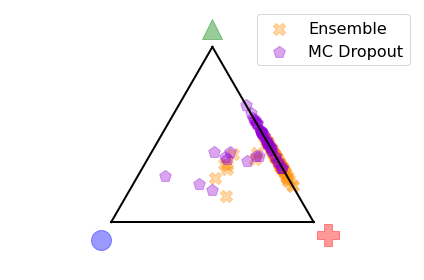

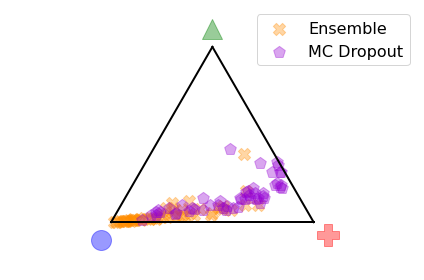

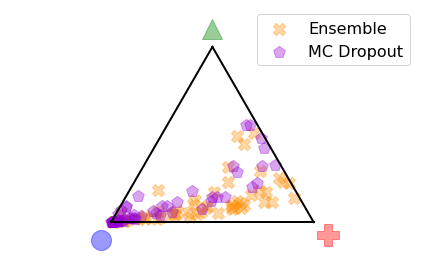

In [245]:
for i, point in enumerate([TEST_POINT1, TEST_POINT2, TEST_POINT3]):
    preds_ensemble = classification_ensemble.get_predictions(torch.FloatTensor(point))
    preds_mcdropout = classification_mcdropout.get_predictions(torch.FloatTensor(point))
    
    preds = {
        "Ensemble": preds_ensemble,
        "MC Dropout": preds_mcdropout
    }
    
    #print(preds_ensemble.shape, preds_ensemble)
    plot_multiple_predictions(
        preds, save_path=f"{IMG_PATH}/ensemble_mc_dropout_classification_{i+1}.png",
        markers=MARKERS,
        colors=COLORS
    )

tensor([0.1024, 0.4998, 0.3978], grad_fn=<DivBackward0>)
tensor([1.0023, 4.5573, 5.7206], grad_fn=<AddBackward0>)


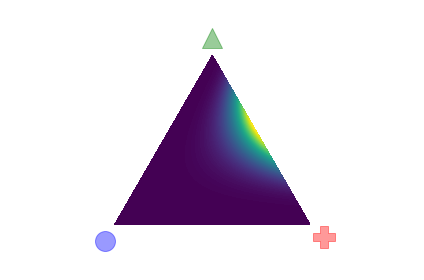

tensor([0.2787, 0.5365, 0.1848], grad_fn=<DivBackward0>)
tensor([1.5507, 5.1182, 1.8622], grad_fn=<AddBackward0>)


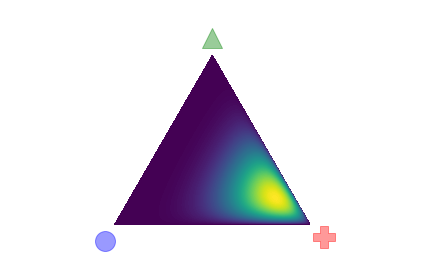

tensor([0.5773, 0.3156, 0.1071], grad_fn=<DivBackward0>)
tensor([1.5340, 1.6673, 1.7799], grad_fn=<AddBackward0>)


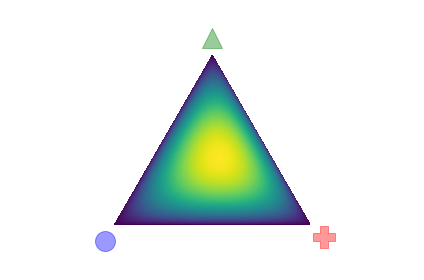

In [246]:
for i, point in enumerate([TEST_POINT1, TEST_POINT2, TEST_POINT3]):
    preds_priornet = classification_priornet.get_predictions(torch.FloatTensor(point))
    print(preds_priornet)
    alphas_priornet = classification_priornet.get_alphas(torch.FloatTensor(point))
    print(alphas_priornet)
    draw_pdf_contours(alphas_priornet.detach().numpy(), save_path=f"{IMG_PATH}/priornet_classification_{i+1}.png")

## Regression example

For the regression example, we generate the data ourselves. We do this by defining a function and a noise term.

In [ ]:
def generate_data(num_points: int, seed: int = 1234):
    np.random.seed(seed)
    x = np.arange(0, 10, 10 / num_points)
    
    func = lambda x: np.sin(x) + 0.3 * x + 0.1
    noise = np.random.randn(*x.shape)
    
    return x, func(x), func(x) + noise / 8


def generate_data2(num_points: int, seed: int = 1234):
    np.random.seed(seed)
    x = np.arange(-10, 10, 20 / num_points)
    
    func = lambda x: x ** 3
    noise = np.random.randn(*x.shape) * 3
    
    return x, func(x), func(x) + noise

In [ ]:
# Plot the data!

plt.figure(figsize=(8, 6), dpi=80)
ax = plt.gca()
plt.grid(visible=True)
x, true_y, y = generate_data(num_points=1000)

removal_range = [230, 575]

def cut_data(arr, removal_range):
    return np.concatenate((arr[:removal_range[0] + 1], arr[removal_range[1]:]), axis=0)


plt.plot(x, true_y, alpha=0.6, color="red", label="True function", linewidth=4)
plt.scatter(x, y, alpha=0.4, color="blue", label="Observations", s=20)

ax.set_xlabel("x", fontsize = 16)
ax.set_ylabel('y', fontsize = 16)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.legend(fontsize=16)
plt.savefig(f"{IMG_PATH}/regression_example.png")
plt.show()

In [ ]:
HIDDEN_SIZE = 200
NUM_LAYERS = 5
LEARNING_RATE = 0.001
NUM_MEMBERS = 10
NUM_PREDICTIONS = 10
BATCH_SIZE = 100
NUM_EPOCHS = 20
REGULARIZATION_FACTOR = 0.1

In [ ]:
class RegressionEnsemble(MultiPredictionModel):
    
    def __init__(
        self, input_size: int, hidden_size: int, num_layers: int, num_members: int, 
        learning_rate: float = 0.001, dropout: float = 0.1
    ):
        super().__init__()
        sizes = [input_size] + num_layers * [hidden_size]
 
        modules = []
        
        for (i, j) in zip(sizes[:-1], sizes[1:]):
            modules.append(nn.Dropout(dropout))
            modules.append(nn.Linear(i, j))
            modules.append(nn.ReLU())
        
        self.models = nn.ModuleList([
            nn.Sequential(
                *modules,
                nn.Linear(sizes[-1], 1)
            ) for _ in range(num_members)
        ])
        
        self.loss_function = nn.MSELoss()
        self.optimizer = torch.optim.Adam(
            params=self.models.parameters(),
            lr=learning_rate
        )
    
    def get_loss(self, x: torch.FloatTensor, y: torch.LongTensor):
        
        loss = 0
        
        for model in self.models:
            loss += self.loss_function(model(x), y)
            
        return loss
    
    def get_predictions(self, x: torch.FloatTensor):
        
        preds = []
        
        for model in self.models:
            pred = model(x)
            preds.append(pred)
            
        preds = torch.stack(preds)
        
        return preds

    
class RegressionMCDropout(MultiPredictionModel):
    
    def __init__(
        self, input_size: int, hidden_size: int, num_layers: int, num_predictions: int, 
        learning_rate: float = 0.001, dropout: float = 0.1
    ):
        super().__init__()
        sizes = [input_size] + num_layers * [hidden_size]
        modules = []
        self.num_predictions = num_predictions
        
        for (i, j) in zip(sizes[:-1], sizes[1:]):
            modules.append(nn.Dropout(dropout))
            modules.append(nn.Linear(i, j))
            modules.append(nn.ReLU())
        
        self.model = nn.Sequential(
            *modules,
            nn.Linear(sizes[-1], 1)
        )
        
        self.loss_function = nn.MSELoss()
        self.optimizer = torch.optim.Adam(
            params=self.model.parameters(),
            lr=learning_rate
        )
        
    def get_predictions(self, x: torch.FloatTensor):
        
        preds = []
        self.model.train()
        
        for _ in range(self.num_predictions):
            pred = self.model(x)
            preds.append(pred)
            
        preds = torch.stack(preds)
        
        return preds
    
    def get_loss(self, x: torch.FloatTensor, y: torch.LongTensor):
        
        loss = 0
        self.model.train()
        
        for _ in range(self.num_predictions):
            loss += self.loss_function(self.model(x), y)
            
        return loss
    

In [ ]:
class RegressionPriorNetwork(Model):
    
    def __init__(
        self, input_size: int, hidden_size: int, num_layers: int, 
        learning_rate: float = 0.001, dropout: float = 0.1, regularization_factor: float = 0.1
    ):
        super().__init__()
        self.regularization_factor = regularization_factor
        
        sizes = [input_size] + num_layers * [hidden_size]
        modules = []
        
        for (i, j) in zip(sizes[:-1], sizes[1:]):
            modules.append(nn.Dropout(dropout))
            modules.append(nn.Linear(i, j))
            modules.append(nn.ReLU())
        
        self.model = nn.Sequential(
            *modules,
            nn.Linear(sizes[-1], 4),
        )
        
        self.optimizer = torch.optim.Adam(
            params=self.model.parameters(),
            lr=learning_rate
        )
        
    def get_loss(self, x: torch.FloatTensor, y: torch.LongTensor):
        # Use approximations provided by Charpentier et al. (2021) for numerical stability
        log_gamma_approx = lambda arg: 0.5 * math.log(2 * math.pi) - arg + (arg - 0.5) * torch.log(arg)

        # Get model outputs
        loss = 0
        output = self.model(x)
        gamma, raw_nu, raw_alpha, raw_beta = output.split(1, dim=-1)
        nu = torch.nn.functional.softplus(raw_nu)
        alpha = torch.nn.functional.softplus(raw_alpha) + 1
        beta = torch.nn.functional.softplus(raw_beta)
       
        # Get loss
        Omega = 2 * beta * (1 + nu)
        loss += 0.5 * torch.log(math.pi / nu) - alpha * torch.log(Omega)
        loss += (alpha + 0.5) * torch.log( nu * (y - gamma) ** 2 + Omega)
        loss += log_gamma_approx(alpha) - log_gamma_approx(alpha + 0.5)
        loss = loss.mean()
        
        # Add regularizer
        reg_term = torch.abs(y - gamma) * (2 * nu + alpha)
        loss += self.regularization_factor * reg_term.mean()
        
        return loss
    
    def get_predictions(self, x: torch.FloatTensor):
        
        output = self.model(x)
        gamma = output[:, 0]
        
        return gamma
    
    def get_uncertainty(self, x: torch.FloatTensor):
        
        output = self.model(x)
        gamma, raw_nu, raw_alpha, raw_beta = output.split(1, dim=-1)
        nu = torch.nn.functional.softplus(raw_nu)
        alpha = torch.nn.functional.softplus(raw_alpha) + 1
        beta = torch.nn.functional.softplus(raw_beta)
        
        #return beta * (1 + nu) / (nu * alpha)
        return beta / (nu * (alpha - 1))
        

In [ ]:
regression_ensemble = RegressionEnsemble(
    input_size=1, hidden_size=200, num_layers=3, 
    num_members=NUM_MEMBERS, learning_rate=0.01
)

In [ ]:
regression_mcdropout = RegressionMCDropout(
    input_size=1, hidden_size=200, num_layers=3, 
    num_predictions=NUM_PREDICTIONS, learning_rate=0.01
)

In [ ]:
regression_priornet = RegressionPriorNetwork(
    input_size=1, hidden_size=200, num_layers=3, 
    learning_rate=0.0005, regularization_factor=0.001
)

In [ ]:
mean, std = np.mean(y), np.std(y)
scaled_y = (y - mean) / std

train_x = cut_data(x, removal_range)
train_y = cut_data(scaled_y, removal_range)

# Create dataloader 
split_regression_data = list(zip(
    [x for x in torch.FloatTensor(train_x).squeeze().split(1)], 
    [y for y in torch.FloatTensor(train_y).squeeze().split(1)]
))

regression_data_loader = torch.utils.data.DataLoader(
    split_regression_data, 
    batch_size=BATCH_SIZE,
    shuffle=True
)


In [ ]:
regression_ensemble.train(regression_data_loader, num_epochs=500)

In [ ]:
regression_mcdropout.train(regression_data_loader, num_epochs=500)

In [ ]:
regression_priornet.train(regression_data_loader, num_epochs=500)

In [ ]:
plot_x = np.arange(-2, 12, 0.1)
preds_ensemble = regression_ensemble.get_predictions(torch.FloatTensor(plot_x).unsqueeze(dim=-1)).squeeze().detach().numpy()
preds_mcdropout = regression_mcdropout.get_predictions(torch.FloatTensor(plot_x).unsqueeze(dim=-1)).squeeze().detach().numpy()
preds_priornet_mean = regression_priornet.get_predictions(torch.FloatTensor(plot_x).unsqueeze(dim=-1)).squeeze().detach().numpy()
preds_priornet_var = regression_priornet.get_uncertainty(torch.FloatTensor(plot_x).unsqueeze(dim=-1))
preds_priornet_std = np.sqrt(preds_priornet_var.squeeze().detach().numpy() * std)

# Scale back
preds_ensemble = preds_ensemble * std + mean
preds_mcdropout = preds_mcdropout * std + mean
preds_priornet_mean = preds_priornet_mean * std + mean

# Smooth for plotting
from scipy.ndimage.filters import gaussian_filter1d
sigma = 1.25

preds_ensemble = gaussian_filter1d(preds_ensemble, sigma=sigma)
preds_mcdropout = gaussian_filter1d(preds_mcdropout, sigma=sigma)
preds_priornet_mean = gaussian_filter1d(preds_priornet_mean, sigma=sigma)
preds_priornet_std = gaussian_filter1d(preds_priornet_std, sigma=sigma)

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
ax = plt.gca()
plt.grid(visible=True)

plt.plot(x, true_y, alpha=0.6, color="red", label="True function", linewidth=4)
plt.scatter(train_x, train_y * std + mean, alpha=0.4, color="black", label="Observations", s=10)

# Plot ensemble
preds_ensemble_mean, preds_ensemble_std = preds_ensemble.mean(axis=0), preds_ensemble.std(axis=0)
plt.plot(plot_x, preds_ensemble_mean, alpha=0.6, color="blue", label="Ensemble", linewidth=2)
plt.fill_between(plot_x, preds_ensemble_mean - preds_ensemble_std, preds_ensemble_mean + preds_ensemble_std, alpha=.2, color='blue')

# Plot MC Dropout
preds_mcdropout_mean, preds_mcdropout_std = preds_mcdropout.mean(axis=0), preds_mcdropout.std(axis=0)
plt.plot(plot_x, preds_mcdropout_mean, alpha=0.6, color="green", label="MC Dropout", linewidth=2)
plt.fill_between(plot_x, preds_mcdropout_mean - preds_mcdropout_std, preds_mcdropout_mean + preds_mcdropout_std, alpha=.2, color='green')
  
# Plot priornet 
plt.plot(plot_x, preds_priornet_mean, alpha=0.6, color="orange", label="Prior Network", linewidth=2)
plt.fill_between(plot_x, preds_priornet_mean - preds_priornet_std, preds_priornet_mean + preds_priornet_std, alpha=.2, color='orange')
plt.ylim([-0.5, 4.5])

plt.show()